Title: Color Histograms
Author: Thomas Breuel
Institution: UniKL

In [187]:

from pylab import *
import tables
from collections import Counter

# Simple Color Histograms

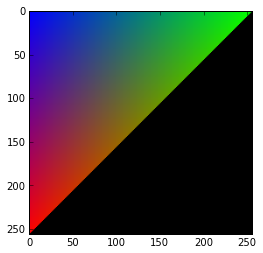

In [201]:
# simple visualization of projected RGB space
cspace = zeros((256,256,3))
for i in range(256):
    for j in range(256):
        x = (i/255.0)
        y = (j/255.0)
        if x+y>1: continue
        z = 1-x-y
        rgb = array([x,y,z])
        cspace[i,j,:] = rgb
imshow(cspace)

In [202]:
# color histogram in projected RGB space
def chist(image,r=15):
    if image.dtype==dtype('B'): image = image/255.0
    result = zeros((r+1,r+1))
    assert image.ndim==3
    rgb = image.reshape(-1,3)
    intensity = sum(rgb,axis=1)
    rgb = rgb[(intensity>0.02)*(intensity<0.98)]
    rgb = r*rgb*1.0/sum(rgb,axis=1)[:,newaxis]
    xy = array(rgb,'i')[:,:2]
    index = xy[:,0]*r+xy[:,1]
    counts = Counter(index)
    for k,v in counts.items(): result[k//r,k%r] = v
    return result

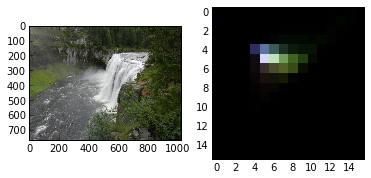

In [209]:
# computing a color histogram of an image
image = imread("raw_images/DSCN0314.JPG")
subplot(121); imshow(image)
c = chist(image); c = c*1.0/amax(c)
cs = (c[:,:,newaxis]**.5)*cspace[::16,::16,:]; cs = cs*1.0/amax(cs)
subplot(122); imshow(cs,interpolation='nearest',cmap=cm.gray)

# Perceptually More Uniform Spaces

Better Color Space:

The projected RGB space above is not a very good space to work in because differences in color are not uniform:

- colors that appear similar have different RGB vectors
- colors that appear different have similar RGB vectors

Other color spaces reduce these effects. 

The $Lab$ space is a popular color space.

$Lab$ coordinates refer to: $L$ intensity; $a$, $b$  color opponent channels.

0.174926254719 100.0
-23.2297308765 10.3329353714
-11.9753707941 48.5577698808


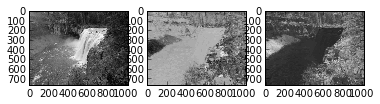

In [210]:
# conversion to Lab color space
from skimage import io,color
lab = color.rgb2lab(image)
for i in range(3):
    subplot(1,3,i+1); imshow(lab[:,:,i],cmap=cm.gray)
    print amin(lab[:,:,i]),amax(lab[:,:,i])

In [193]:

def ifloor(a): return array(a,'i')

Let's rewrite the `chist` function. Now it computes color histograms using intensity and color information, and using an Lab color space. Computation of the histogram is loop-free.



In [194]:
def chist(image,iq=3,cq=7):
    lab = color.rgb2lab(image).reshape(-1,3)
    lab = lab[lab[:,0]>1.0]
    lab[:,0] = lab[:,0]*iq/100.0
    lab[:,1] = (lab[:,1]+128.0)*cq/255.0
    lab[:,2] = (lab[:,2]+128.0)*cq/255.0
    index = ifloor(lab[:,0])*cq*cq+ifloor(lab[:,1])*cq+ifloor(lab[:,2])
    counts = Counter(index)
    result = zeros((iq+1)*(cq+1)*(cq+1))
    for k,v in counts.items(): result[k] = v
    return result

Let's visualize the output. Note that we get four intensity levels of 8x8 color histograms.



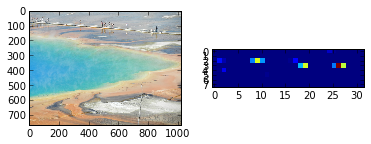

In [195]:
image = imread("raw_images/DSCN0243.JPG")
subplot(121); imshow(image)
subplot(122); imshow(chist(image).reshape(8,-1)**.5,interpolation='nearest')

# Precomputing Histograms

We now just use the low resolution "icons" stored in HDF5 to compute the color histograms. This is sufficient for histogram-based retrieval.



In [196]:
hdf = tables.openFile("sample.h5","r")

Computation of color histograms is very simple...



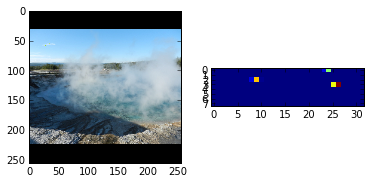

In [197]:
hists = [chist(image) for image in hdf.root.icons]

subplot(121); imshow(hdf.root.icons[20])
subplot(122); imshow(hists[20].reshape(8,-1),interpolation='nearest')

# Histogram Search

For searching by color histogram similarity, we use the _cosine distance_.

That is, each histogram is viewed as a vector, and the dissimilarity between vectors is given by:

$$ d(u,v) = 1 - \frac{u\cdot v}{||u|| ~ ||v||} $$

Distance calculations are efficiently implemented by `scipy.spatial.distance`

(For large scale nearest neighbor search, we use a different approach.)

[154 153 192 146  99 147 125 124 193]


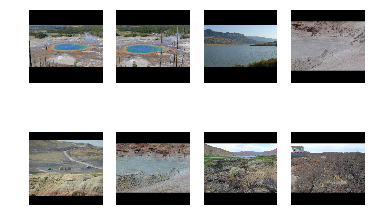

In [199]:
# search by color histogram similarity
from scipy.spatial import distance
dists = distance.cdist(hists[154].reshape(1,-1),hists,'cosine')
nearest = argsort(dists.ravel())
print nearest[:9]
for f,i in enumerate(nearest[:8]):
    subplot(2,4,f+1); axis("off"); imshow(hdf.root.icons[i])